# Basic Model: SVM

### Import necessary packages

In [1]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler

import mlflow
import logging 
import config 

from basic_functions import (
    get_preprocess_data,
    get_lemmatized_data,
    get_metrics
)


/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

In [2]:
MODEL_NAME = "SVM" 
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [3]:
DATA_PATH = "../data/data_training_ss.csv"

### Get and process data

In [4]:
df = get_preprocess_data(DATA_PATH)

### Lemmatize text

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/maren/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
df.head()

,text,logical_fallacies,source
dataset,,,
9,republicans talk about it but we re the first ...,appeal_to_emotion,NaN
3,it seems like the police and the government of...,none,NaN
5,when 3 per cent of total annual global emissio...,none,NaN
4,why don t we see a scientific natural immunity...,appeal_to_emotion,NaN
3,telegram either has to ban these people or ban...,false_dilemma,NaN


In [7]:
df = get_lemmatized_data(df)

### Train-test split

In [8]:
y = df["logical_fallacies"]
X = df["text"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

### SVM

In [9]:
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()
mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "svm baseline")
# mlflow.log_params(params)

In [10]:
# Use TF-IDF Vecorizer to transform text into numerical data
tfidf_vectorizer = TfidfVectorizer()
X_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_vectorized_test = tfidf_vectorizer.transform(X_test)

In [11]:
# # Oversampling only on train dataset
# ros = RandomOverSampler(random_state=0)
# X_resampled_train, y_resampled_train = ros.fit_resample(X_vectorized, y_train)

In [12]:
# Grid search
param_grid = {
'C': [0.1, 1, 10, 100],
'gamma': ['scale', 'auto'],
'kernel': ['linear', 'rbf']
}

svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="f1_weighted")
grid_search.fit(X_vectorized, y_train)

best_params = grid_search.best_params_
print(best_params)

# Predict on train and test data
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_vectorized)
y_test_pred = best_model.predict(X_vectorized_test)

mlflow.log_params(best_params)

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [14]:
# Save model to pickle file:
with open('../models/svm/svm_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

### Evaluation


In [15]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metri

INFO:root:get_train_metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.92      0.94      0.93       591
appeal_to_authority       0.96      0.90      0.93       508
  appeal_to_emotion       0.90      0.93      0.91       615
      false_dilemma       0.96      0.91      0.93       586
               none       0.90      0.95      0.92       761
     slippery_slope       0.96      0.94      0.95       439

           accuracy                           0.93      3500
          macro avg       0.93      0.93      0.93      3500
       weighted avg       0.93      0.93      0.93      3500

[[557   6  13   3  12   0]
 [ 10 459  15   3  15   6]
 [ 22   3 570   5  14   1]
 [  8   1   9 531  33   4]
 [  8   7  13   7 720   6]
 [  2   2  12   4   7 412]]


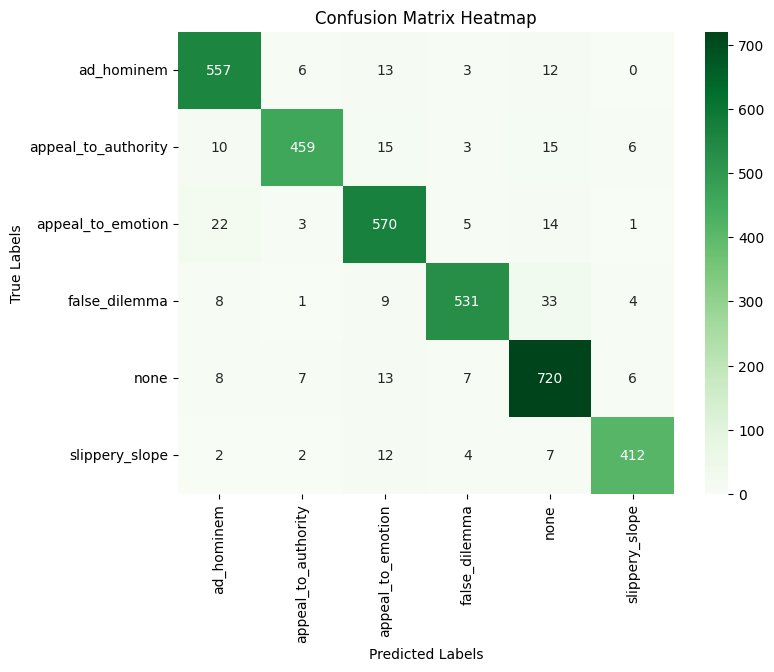

In [17]:
logger.info('get_train_metrics')
classification_report_train = get_metrics(y_train, y_train_pred)
log_metrics(classification_report_train, "train")

INFO:root:get_test_metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.67      0.67      0.67       253
appeal_to_authority       0.69      0.60      0.64       218
  appeal_to_emotion       0.56      0.63      0.59       263
      false_dilemma       0.74      0.68      0.71       251
               none       0.57      0.63      0.60       327
     slippery_slope       0.76      0.68      0.72       188

           accuracy                           0.65      1500
          macro avg       0.66      0.65      0.65      1500
       weighted avg       0.65      0.65      0.65      1500

[[170  14  39   8  22   0]
 [ 13 130  26   5  36   8]
 [ 40  10 166  11  27   9]
 [ 12   4  16 170  42   7]
 [ 19  23  35  29 205  16]
 [  1   7  15   8  29 128]]


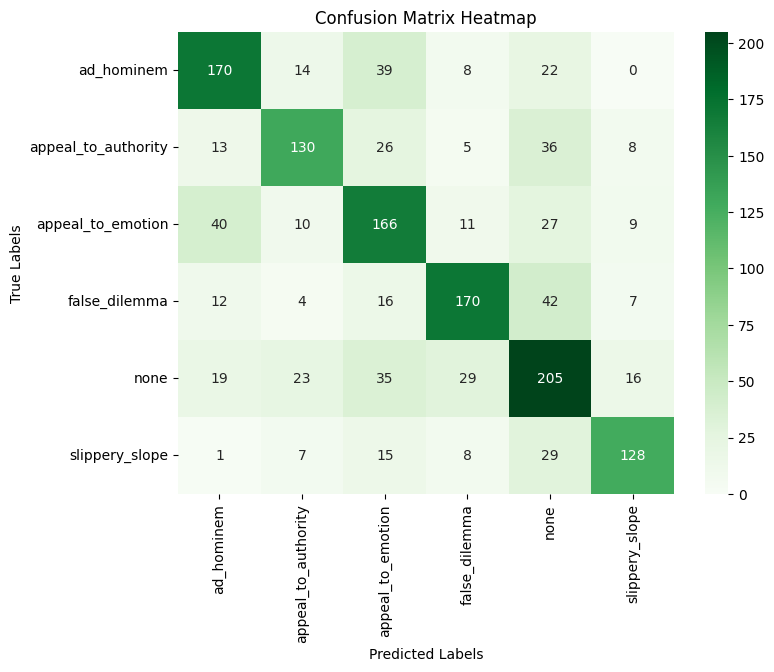

In [18]:
logger.info('get_test_metrics')
classification_report_test = get_metrics(y_test, y_test_pred)
log_metrics(classification_report_test, "test")

In [17]:
mlflow.end_run()

🏃 View run svm baseline at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/00f057b2d102426cbae6a969c622265c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451
